In [121]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import zipfile
import json
import os
import time
from PIL import Image, ImageDraw, ImageFilter, ImageOps


#Very hacky fix to make matplotlib work on my pc
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

base_dir = "/home/fsuser/" # install git repo in this directory
repo_dir = base_dir + "de-identification/"
data_path = repo_dir+"downloaded-data/"
images_path = data_path+"celeba_faces_cropped/"

Random Seed:  999


Images for /home/fsuser/de-identification/downloaded-data/celeba_faces_cropped/


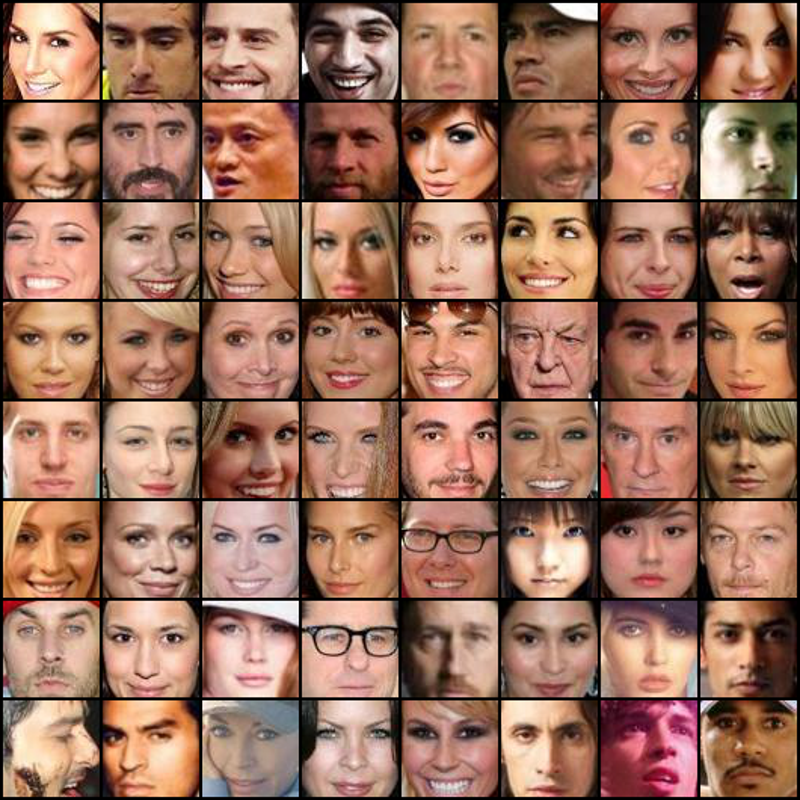

In [122]:
class ImageDataset(Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.all_imgs = list(sorted(os.listdir(root)))

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        image = Image.open(self.root+self.all_imgs[idx])
        image = self.transform(image)
        return image


print(f"Images for {images_path}")

img_transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

assert len(os.listdir(images_path)) > 0, "No images found in data path"
dataset = ImageDataset(images_path, img_transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
batch = next(iter(dataloader))
display_img = Image.fromarray((vutils.make_grid(batch[:64], padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))
display(ImageOps.contain(display_img, (800, 800)))

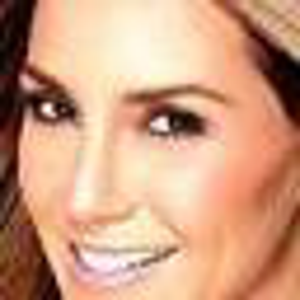

In [123]:
display_img = Image.fromarray((vutils.make_grid(batch[0], padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))
display(ImageOps.contain(display_img, (300, 300)))

In [124]:
datapath = data_path+"celeba_faces_cropped/"
version = 'detection-10-epochs'

In [125]:
# Generator Code

nz = 100 # Size of z latent vector (i.e. size of generator input)
nc = 3 # Number of channels in the training images. For color images this is 3
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
ngpu = 1 # Number of GPUs available. Use 0 for CPU mode.

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

#load models
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
models_dir = repo_dir + "pretrained-models/"
version = 'detection-10-epochs' # need 
netG_loaded = Generator(ngpu).to(device)
netG_loaded.load_state_dict(torch.load(models_dir + f"DCGAN-{version}-netG.pth"))
netG_loaded.eval()

netD_loaded = Discriminator(ngpu).to(device)
netD_loaded.load_state_dict(torch.load(models_dir + f"DCGAN-{version}-netD.pth"))
netD_loaded.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

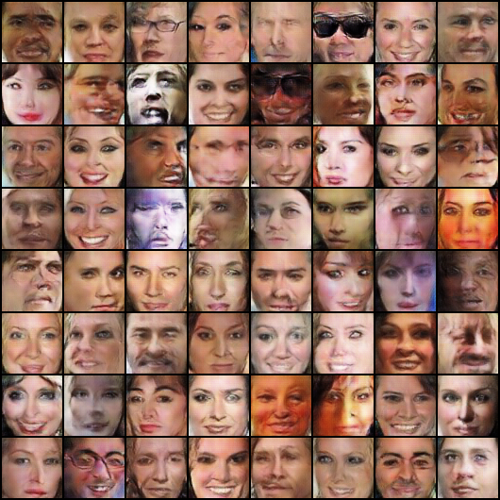

In [126]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
with torch.no_grad():
    generated_faces = netG_loaded(fixed_noise).cpu()

display_img = Image.fromarray((vutils.make_grid(generated_faces, padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))
display(ImageOps.contain(display_img, (500,500)))

In [127]:
#### Hyperparameters ###
def inpaint_face(real_face, border_factor = 0.1):
    real_face = real_face.unsqueeze(dim=0)

    lr = 0.3
    iterations = 1000
    eval_interval = 250
    lam = 0.1 # perceptual_loss factor

    border_width = int(64 * border_factor)
    mask = torch.ones(1, 3, 64, 64)
    mask[:, :, border_width:-border_width, border_width:-border_width] = 0

    fixed_noise = torch.randn(1, nz, 1, 1, device=device).requires_grad_(True)
    fixed_noise, real_face, mask = fixed_noise.to(device), real_face.to(device), mask.to(device)

    with torch.no_grad():
        fake_faces = netG_loaded(fixed_noise)

    results=[fake_faces.clone()]

    criterion = nn.BCELoss()
    optimizer = optim.Adam([fixed_noise], lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, iterations)

    t_start = time.time()
    for i in range(iterations):
        fake_faces = netG_loaded(fixed_noise)
        contextual_loss = nn.functional.l1_loss(mask*fake_faces, mask*real_face.repeat(batch_size, 1, 1, 1))


        real_label = torch.ones(batch_size).to(device)
        d_output = netD_loaded(fake_faces).view(-1) # detach??
        perceptual_loss = criterion(d_output, real_label) #g_loss

        complete_loss = contextual_loss + lam*perceptual_loss
        if i == 0:
            print("Starting losses:: Complete:{:.4f}, contextual:{:.4f}, perceptual:{:.4f} (after x0.1)".format(complete_loss, contextual_loss, lam*perceptual_loss))

        optimizer.zero_grad()
        complete_loss.backward()
        optimizer.step()
        scheduler.step()

        if i % eval_interval == eval_interval-1:
            # print(f"i: {i} Losses:: Complete:{complete_loss:.4f}, contextual:{contextual_loss:.4f}, perceptual:{lam*perceptual_loss:.4f} (after x0.1), time: {time.time()-t_start:.2f}s")
            results.append(fake_faces.clone())

    print(f"Final Losses ({i+1} iterations):: Complete:{complete_loss:.4f}, contextual:{contextual_loss:.4f}, perceptual:{lam*perceptual_loss:.4f} (after x0.1), time: {time.time()-t_start:.2f}s")
    results.append(real_face.clone())
    results_returned = []
    for r in results:
        combined_faces = real_face*mask + fake_faces*(1-mask)
        results_returned.append(combined_faces.detach().cpu()[0])
    
    return results_returned

In [128]:
resulting_faces = []
for real_face in batch[:32]:
    resulting_faces.append(inpaint_face(real_face)[-1])

Starting losses:: Complete:0.4206, contextual:0.1800, perceptual:0.2406 (after x0.1)
Final Losses (1000 iterations):: Complete:0.0392, contextual:0.0389, perceptual:0.0003 (after x0.1), time: 5.09s
Starting losses:: Complete:0.2354, contextual:0.1101, perceptual:0.1253 (after x0.1)
Final Losses (1000 iterations):: Complete:0.0364, contextual:0.0358, perceptual:0.0006 (after x0.1), time: 5.65s
Starting losses:: Complete:0.2239, contextual:0.1137, perceptual:0.1102 (after x0.1)
Final Losses (1000 iterations):: Complete:0.0307, contextual:0.0299, perceptual:0.0008 (after x0.1), time: 3.95s
Starting losses:: Complete:0.1841, contextual:0.1534, perceptual:0.0307 (after x0.1)
Final Losses (1000 iterations):: Complete:0.0382, contextual:0.0378, perceptual:0.0004 (after x0.1), time: 4.83s
Starting losses:: Complete:0.3539, contextual:0.1181, perceptual:0.2358 (after x0.1)
Final Losses (1000 iterations):: Complete:0.0178, contextual:0.0169, perceptual:0.0008 (after x0.1), time: 6.26s
Starting l

In [129]:
faces_to_display = torch.stack(resulting_faces,dim=0)

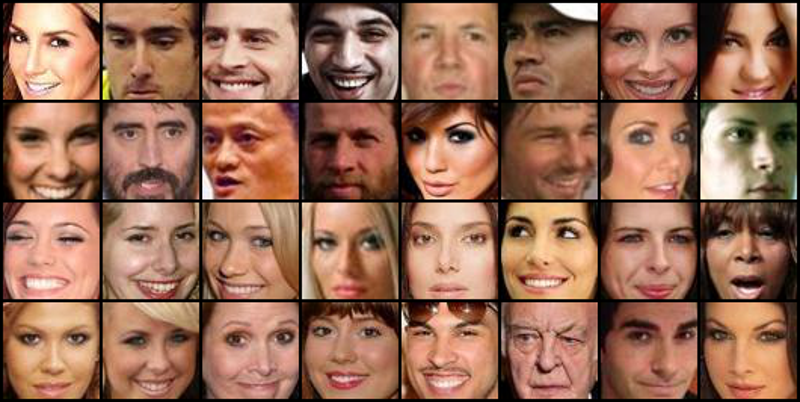

In [130]:
display_img = Image.fromarray((vutils.make_grid(batch[:len(faces_to_display)], padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))
display(ImageOps.contain(display_img, (800, 800)))

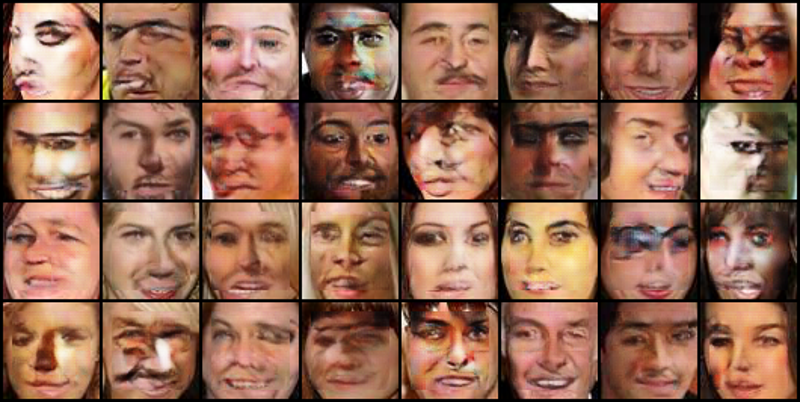

In [131]:
display_img = Image.fromarray((vutils.make_grid(faces_to_display, padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))
display(ImageOps.contain(display_img, (800, 800)))